In [326]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob 
import re 
import tsfresh
import random
import hdbscan
import logging
import umap
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean


In [340]:
#create list for the given amplitude string
def str_to_list(row):  
    list_of_str = row[9].split(',')
    int_list = []
    int_list = [int(i) for i in list_of_str[1:len(list_of_str)-1]]
    int_list.insert(0,int(re.findall(r'-*\d+',list_of_str[0])[0]))
    int_list.append(int(re.findall(r'-*\d+',list_of_str[len(list_of_str)-1])[0]))
    return int_list 

#create a data frame containing data pertaining to one specific node
def node_selection(df,node_name = 'MM104'):
    df = df_all[df_all['f_name'] == node_name][['device_id','collection_time','amps']].copy()
    df['id'] = df.apply(lambda x : str(x[0]) + str(x[1]) , axis = 1)
    df = df.reset_index()
    return df
    
#create a row for each amplitude in the FBC array
def elongate_df(df1):
    df1_long = df1.explode('amps' , ignore_index = True)
    df1_long_feat = df1_long[['id','amps']]
    df1_long_feat.applymap(type).apply(pd.value_counts).fillna(0)
    df1_long_feat['amps'] = df1_long_feat['amps'].astype('int')
    return df1_long_feat

#feature extraction based on a particular setting (eg: MinimalFCParameters,EfficientFCParameters)
def tsfresh_feature_extraction(df,settings=MinimalFCParameters()):
    return extract_features(df, column_id="id", column_value="amps",default_fc_parameters = settings)

#dimensionality reduction
def umap_clust(df,n_neighbors=50,min_dist=0.0,n_components = 2):
    return umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=n_components,random_state=42,).fit_transform(df)

#generate labels using HDBSCAN 
def hdbscan_umap(embedding,min_samples=10,min_cluster_size=50):
    return hdbscan.HDBSCAN(min_samples=min_samples,min_cluster_size=min_cluster_size).fit_predict(clusterable_embedding)

#join original data frame to labels generated
def merge_labels(df1,extracted_feature,labels):
    extracted_feature = extracted_feature.reset_index()
    extracted_feature['labels'] = labels
    return df1.merge(extracted_feature[['index','labels']],left_on='id' , right_on = 'index')

#4 random plots for a particular label
def random_four_plot(df,label,num):
    a= random.randint(0,num-1)
    b= random.randint(0,num-1)
    c= random.randint(0,num-1)
    d= random.randint(0,num-1)
    
    print('Plots for label: {label}'.format(label = label))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1,figsize=(20,7),sharex = True,sharey = True)
    fig.suptitle('Plots for label: {label},Num of members: {num}.Members {a},{b},{c},{d}'.format(label = label,num = num,a=a,b=b,c=c,d=d))
    df1_label = df1_with_labels[df1_with_labels['labels']==label].reset_index()
    
    
    ax1.plot( df1_label['amps'][a] )
    ax2.plot(df1_label['amps'][b]  , 'tab:orange')
    ax3.plot(df1_label['amps'][c]  , 'tab:green')
    ax4.plot(df1_label['amps'][d]  , 'tab:red')

    for ax in fig.get_axes():
        ax.label_outer()
        
#plot 4 random graphs for all labels generated        
def plot_for_all_labels(df,dct):
    print(dct)
    for key,value in dct.items():
        random_four_plot(df,key,value)

#hyper-parameter tuning using gridsearch for hdbscan        
def tune_hdbscan_params(data_df , param_df):
    dbcv_list = []
    for i , ser in param_df.iterrows():
        p1, p2 ,p3 , p4 = ser[0],ser[1],ser[2],ser[3]
        hdb = hdbscan.HDBSCAN(gen_min_span_tree=True,min_samples=p1,min_cluster_size=p2,cluster_selection_method=p3,metric=p4).fit(data_df) 
        dbcv_list.append(hdb.relative_validity_)
    
    param_df['dbcv_score'] = dbcv_list
    return param_df 


#create a data frame to use for grid search
df1_dict = pd.DataFrame({'min_samples' : [i*2 for i in range(1,50)]})
df2_dict = pd.DataFrame({'min_cluster_size' : [i*2 for i in range(1,100)]})
df3_dict = pd.DataFrame({'cluster_selection_method' : ['eom','leaf']})
df4_dict = pd.DataFrame({'metric' : ['euclidean','manhattan']})

df1_dict['key'] = 1
df2_dict['key'] = 1
df3_dict['key'] = 1
df4_dict['key'] = 1

result = pd.merge(df1_dict , df2_dict , on = 'key')
result = pd.merge(result , df3_dict , on='key')
result = pd.merge(result , df4_dict , on='key').drop('key' , axis=1)




In [ ]:
"""
Implimentation of Density-Based Clustering Validation "DBCV"

Citation:
Moulavi, Davoud, et al. "Density-based clustering validation."
Proceedings of the 2014 SIAM International Conference on Data Mining.
Society for Industrial and Applied Mathematics, 2014.
"""

import numpy as np
from scipy.spatial.distance import euclidean, cdist
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csgraph


def DBCV(X, labels, dist_function=euclidean):
    """
    Density Based clustering validation

    Args:
        X (np.ndarray): ndarray with dimensions [n_samples, n_features]
            data to check validity of clustering
        labels (np.array): clustering assignments for data X
        dist_dunction (func): function to determine distance between objects
            func args must be [np.array, np.array] where each array is a point

    Returns: cluster_validity (float)
        score in range[-1, 1] indicating validity of clustering assignments
    """
    graph = _mutual_reach_dist_graph(X, labels, dist_function)
    mst = _mutual_reach_dist_MST(graph)
    cluster_validity = _clustering_validity_index(mst, labels)
    return cluster_validity


def _core_dist(point, neighbors, dist_function):
    """
    Computes the core distance of a point.
    Core distance is the inverse density of an object.

    Args:
        point (np.array): array of dimensions (n_features,)
            point to compute core distance of
        neighbors (np.ndarray): array of dimensions (n_neighbors, n_features):
            array of all other points in object class
        dist_dunction (func): function to determine distance between objects
            func args must be [np.array, np.array] where each array is a point

    Returns: core_dist (float)
        inverse density of point
    """
    n_features = np.shape(point)[0]
    n_neighbors = np.shape(neighbors)[0]

    distance_vector = cdist(point.reshape(1, -1), neighbors)
    distance_vector = distance_vector[distance_vector != 0]
    numerator = ((1/distance_vector)**n_features).sum()
    core_dist = (numerator / (n_neighbors - 1)) ** (-1/n_features)
    return core_dist


def _mutual_reachability_dist(point_i, point_j, neighbors_i,
                              neighbors_j, dist_function):
    """.
    Computes the mutual reachability distance between points

    Args:
        point_i (np.array): array of dimensions (n_features,)
            point i to compare to point j
        point_j (np.array): array of dimensions (n_features,)
            point i to compare to point i
        neighbors_i (np.ndarray): array of dims (n_neighbors, n_features):
            array of all other points in object class of point i
        neighbors_j (np.ndarray): array of dims (n_neighbors, n_features):
            array of all other points in object class of point j
        dist_dunction (func): function to determine distance between objects
            func args must be [np.array, np.array] where each array is a point

    Returns: mutual_reachability (float)
        mutual reachability between points i and j

    """
    core_dist_i = _core_dist(point_i, neighbors_i, dist_function)
    core_dist_j = _core_dist(point_j, neighbors_j, dist_function)
    dist = dist_function(point_i, point_j)
    mutual_reachability = np.max([core_dist_i, core_dist_j, dist])
    return mutual_reachability


def _mutual_reach_dist_graph(X, labels, dist_function):
    """
    Computes the mutual reach distance complete graph.
    Graph of all pair-wise mutual reachability distances between points

    Args:
        X (np.ndarray): ndarray with dimensions [n_samples, n_features]
            data to check validity of clustering
        labels (np.array): clustering assignments for data X
        dist_dunction (func): function to determine distance between objects
            func args must be [np.array, np.array] where each array is a point

    Returns: graph (np.ndarray)
        array of dimensions (n_samples, n_samples)
        Graph of all pair-wise mutual reachability distances between points.

    """
    n_samples = np.shape(X)[0]
    graph = []
    counter = 0
    for row in range(n_samples):
        graph_row = []
        for col in range(n_samples):
            point_i = X[row]
            point_j = X[col]
            class_i = labels[row]
            class_j = labels[col]
            members_i = _get_label_members(X, labels, class_i)
            members_j = _get_label_members(X, labels, class_j)
            dist = _mutual_reachability_dist(point_i, point_j,
                                             members_i, members_j,
                                             dist_function)
            graph_row.append(dist)
        counter += 1
        graph.append(graph_row)
    graph = np.array(graph)
    return graph


def _mutual_reach_dist_MST(dist_tree):
    """
    Computes minimum spanning tree of the mutual reach distance complete graph

    Args:
        dist_tree (np.ndarray): array of dimensions (n_samples, n_samples)
            Graph of all pair-wise mutual reachability distances
            between points.

    Returns: minimum_spanning_tree (np.ndarray)
        array of dimensions (n_samples, n_samples)
        minimum spanning tree of all pair-wise mutual reachability
            distances between points.
    """
    mst = minimum_spanning_tree(dist_tree).toarray()
    return mst + np.transpose(mst)


def _cluster_density_sparseness(MST, labels, cluster):
    """
    Computes the cluster density sparseness, the minimum density
        within a cluster

    Args:
        MST (np.ndarray): minimum spanning tree of all pair-wise
            mutual reachability distances between points.
        labels (np.array): clustering assignments for data X
        cluster (int): cluster of interest

    Returns: cluster_density_sparseness (float)
        value corresponding to the minimum density within a cluster
    """
    indices = np.where(labels == cluster)[0]
    cluster_MST = MST[indices][:, indices]
    cluster_density_sparseness = np.max(cluster_MST)
    return cluster_density_sparseness


def _cluster_density_separation(MST, labels, cluster_i, cluster_j):
    """
    Computes the density separation between two clusters, the maximum
        density between clusters.

    Args:
        MST (np.ndarray): minimum spanning tree of all pair-wise
            mutual reachability distances between points.
        labels (np.array): clustering assignments for data X
        cluster_i (int): cluster i of interest
        cluster_j (int): cluster j of interest

    Returns: density_separation (float):
        value corresponding to the maximum density between clusters
    """
    indices_i = np.where(labels == cluster_i)[0]
    indices_j = np.where(labels == cluster_j)[0]
    shortest_paths = csgraph.dijkstra(MST, indices=indices_i)
    relevant_paths = shortest_paths[:, indices_j]
    density_separation = np.min(relevant_paths)
    return density_separation


def _cluster_validity_index(MST, labels, cluster):
    """
    Computes the validity of a cluster (validity of assignmnets)

    Args:
        MST (np.ndarray): minimum spanning tree of all pair-wise
            mutual reachability distances between points.
        labels (np.array): clustering assignments for data X
        cluster (int): cluster of interest

    Returns: cluster_validity (float)
        value corresponding to the validity of cluster assignments
    """
    min_density_separation = np.inf
    for cluster_j in np.unique(labels):
        if cluster_j != cluster:
            cluster_density_separation = _cluster_density_separation(MST,
                                                                     labels,
                                                                     cluster,
                                                                     cluster_j)
            if cluster_density_separation < min_density_separation:
                min_density_separation = cluster_density_separation
    cluster_density_sparseness = _cluster_density_sparseness(MST,
                                                             labels,
                                                             cluster)
    numerator = min_density_separation - cluster_density_sparseness
    denominator = np.max([min_density_separation, cluster_density_sparseness])
    cluster_validity = numerator / denominator
    return cluster_validity


def _clustering_validity_index(MST, labels):
    """
    Computes the validity of all clustering assignments for a
    clustering algorithm

    Args:
        MST (np.ndarray): minimum spanning tree of all pair-wise
            mutual reachability distances between points.
        labels (np.array): clustering assignments for data X

    Returns: validity_index (float):
        score in range[-1, 1] indicating validity of clustering assignments
    """
    n_samples = len(labels)
    validity_index = 0
    for label in np.unique(labels):
        fraction = np.sum(labels == label) / float(n_samples)
        cluster_validity = _cluster_validity_index(MST, labels, label)
        validity_index += fraction * cluster_validity
    return validity_index


def _get_label_members(X, labels, cluster):
    """
    Helper function to get samples of a specified cluster.

    Args:
        X (np.ndarray): ndarray with dimensions [n_samples, n_features]
            data to check validity of clustering
        labels (np.array): clustering assignments for data X
        cluster (int): cluster of interest

    Returns: members (np.ndarray)
        array of dimensions (n_samples, n_features) of samples of the
        specified cluster.
    """
    indices = np.where(labels == cluster)[0]
    members = X[indices]
    return members

In [3]:

#
path = '//Users//yashwant//Documents//Documents - Yashwant’s MacBook Pro//Academics//Projects//Cox//fbc//'
df1 = pd.read_csv(path+'//MM106.csv')
csv_files = glob.glob(os.path.join(path, "*.csv"))      


df_all = pd.DataFrame()
file_lenghts = []
length = len(csv_files[0].split('//'))

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df['amps'] = df.apply(str_to_list , axis = 1)
    new_col_name = csv_file.split('//')[length-1].split('.')[0].split('/')[1]
    file_lenghts.append((new_col_name,len(df)))
    df['f_name'] = new_col_name
    df_all = pd.concat([df_all,df] , ignore_index = True)
    
df_all['len_list'] = df_all.apply(lambda x : len(x[14]) , axis = 1)



In [ ]:
#select a node to perform further analysis
df1 = node_selection(df1,node_name = 'MM106')

In [8]:
df_long_feat = elongate_df(df1)

<ipython-input-2-b2e5f073d421>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_long_feat['amps'] = df1_long_feat['amps'].astype('int')


In [12]:

extracted_features = tsfresh_feature_extraction(df_long_feat,settings=EfficientFCParameters())
extracted_feature = extracted_features.dropna(axis  =1)

Feature Extraction: 100%|██████████| 20/20 [32:31<00:00, 97.56s/it]  


In [35]:
clusterable_embedding = umap_clust(extracted_feature,n_neighbors=10,min_dist=0.0,n_components = 5)

In [179]:
#hdbscan after umap
labels = hdbscan_umap(clusterable_embedding,min_samples=4,min_cluster_size=45)

In [366]:
km = KMeans(n_clusters=13, init='k-means++', n_init=10, verbose=0, random_state=None, copy_x=True, algorithm='auto')
km_labels = km.fit_predict(clusterable_embedding)
kmeans_score = DBCV(clusterable_embedding, km_labels, dist_function=euclidean)

kmeans_score

0.08611547573124699

In [180]:
df1_with_labels = merge_labels(df1,extracted_feature,labels)

,min_samples,min_cluster_size,cluster_selection_method,metric
0,2,2,eom,euclidean
1,2,2,eom,manhattan
2,2,2,leaf,euclidean
3,2,2,leaf,manhattan
4,2,4,eom,euclidean
...,...,...,...,...
19399,98,196,leaf,manhattan
19400,98,198,eom,euclidean
19401,98,198,eom,manhattan
19402,98,198,leaf,euclidean


In [ ]:
#data frame for hyper parameter tuning and finding out parameters with respect to highest dbcv score
a=tune_hdbscan_params(clusterable_embedding,result)
a[a['dbcv_score']==a['dbcv_score'].max()]

In [187]:
#DBCV score for best fitted parameters
hdb = hdbscan.HDBSCAN(gen_min_span_tree=True,min_samples=4,min_cluster_size=45,metric='manhattan').fit(clusterable_embedding)
hdb.relative_validity_

In [181]:
dct = dict(df1_with_labels['labels'].value_counts())

{4: 343, 2: 175, 5: 137, 11: 111, 1: 107, 12: 89, 0: 84, 7: 73, 9: 72, 6: 55, 10: 47, 8: 46, 3: 45, -1: 43}
Plots for label: 4
Plots for label: 2
Plots for label: 5
Plots for label: 11
Plots for label: 1
Plots for label: 12
Plots for label: 0
Plots for label: 7
Plots for label: 9
Plots for label: 6
Plots for label: 10
Plots for label: 8
Plots for label: 3
Plots for label: -1


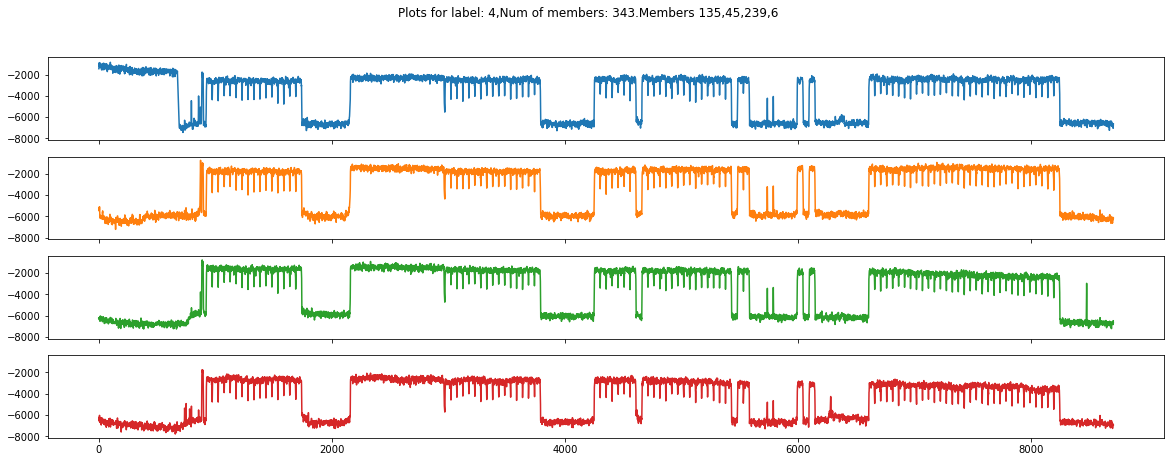

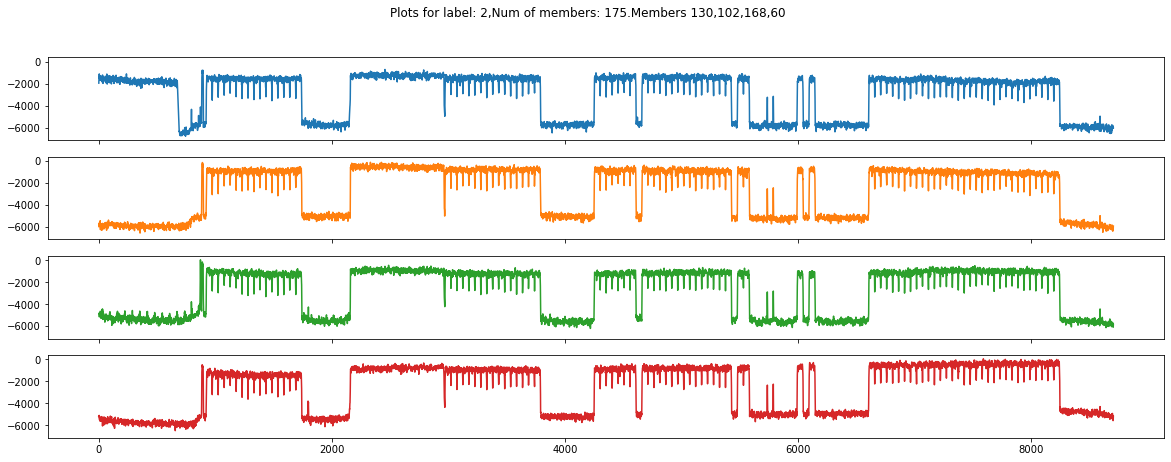

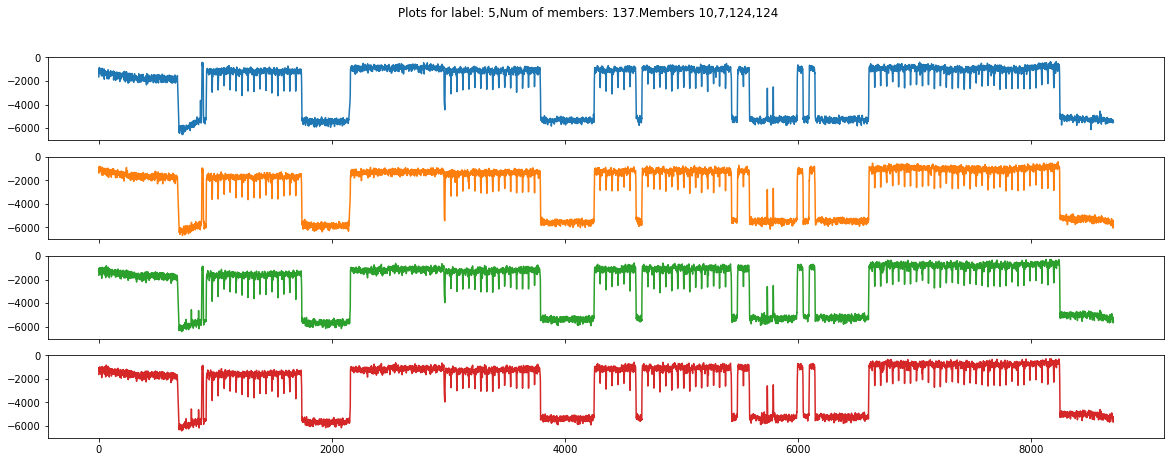

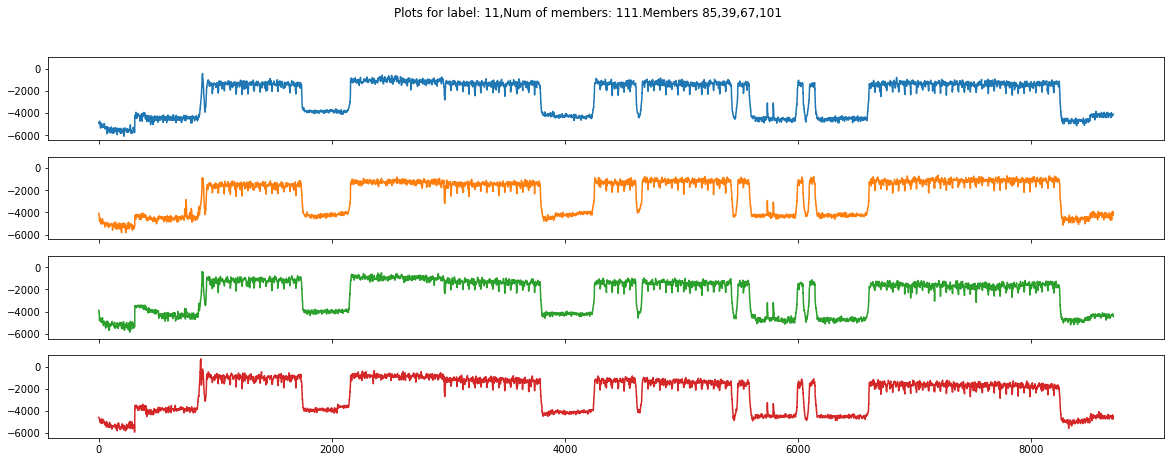

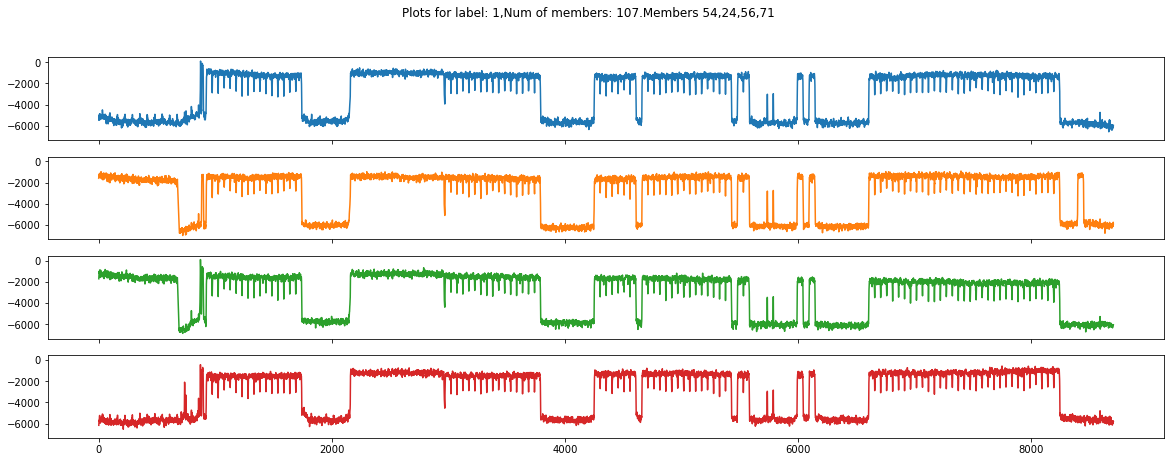

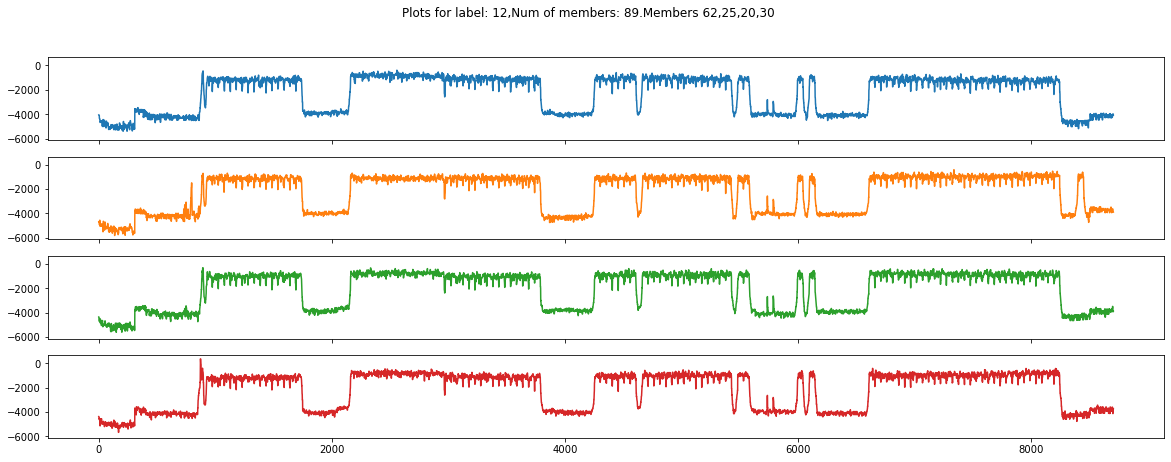

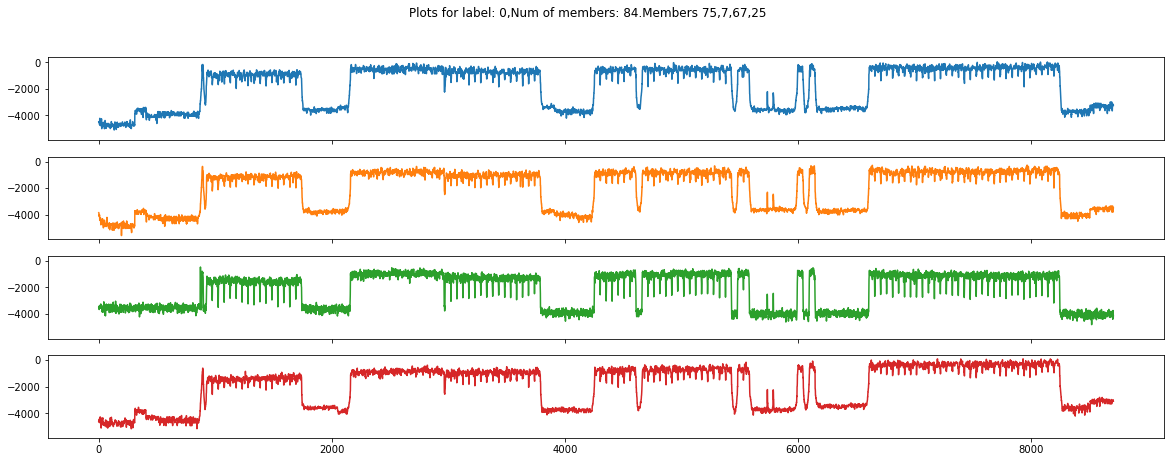

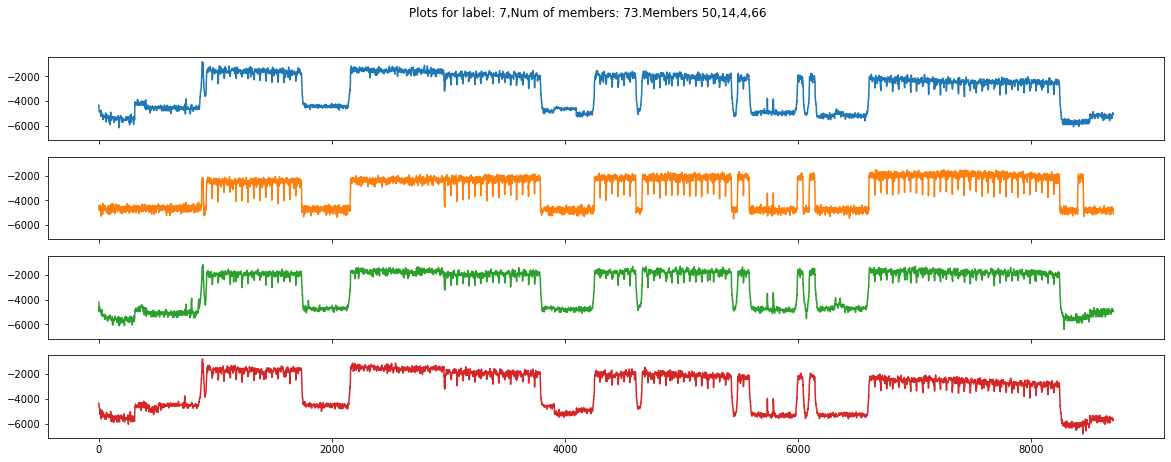

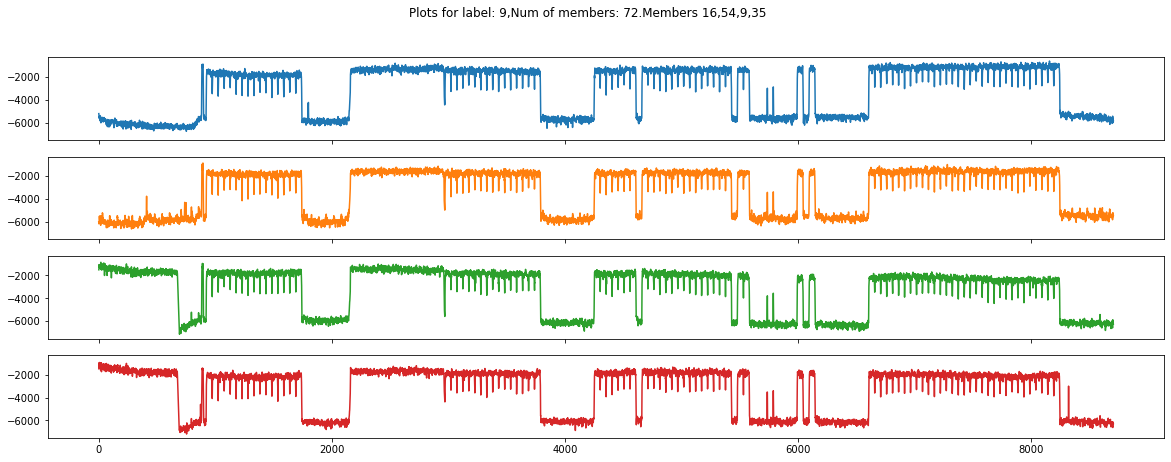

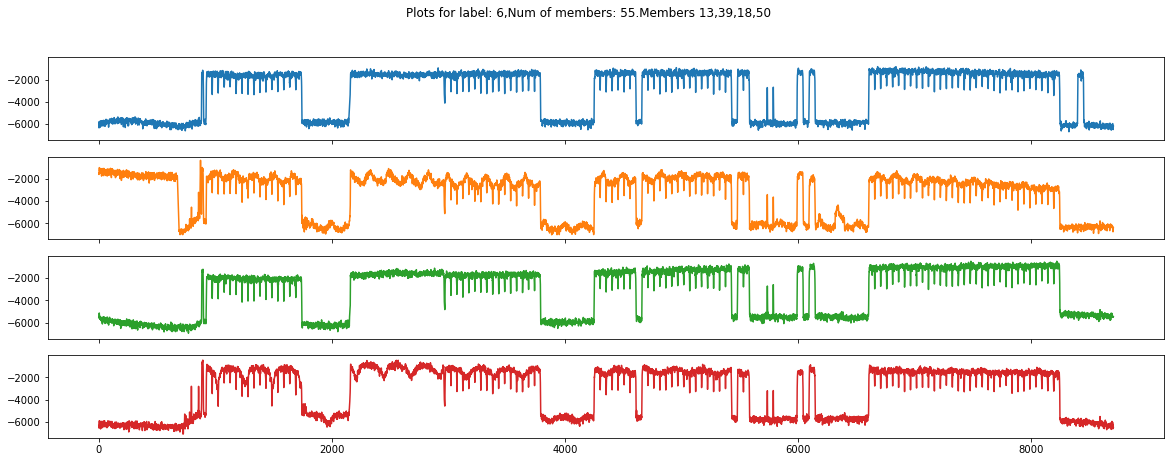

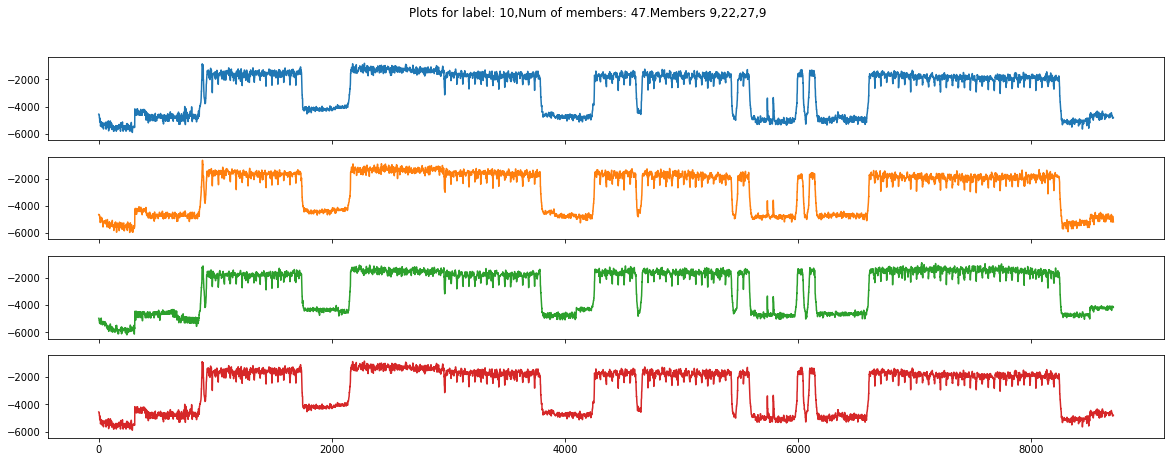

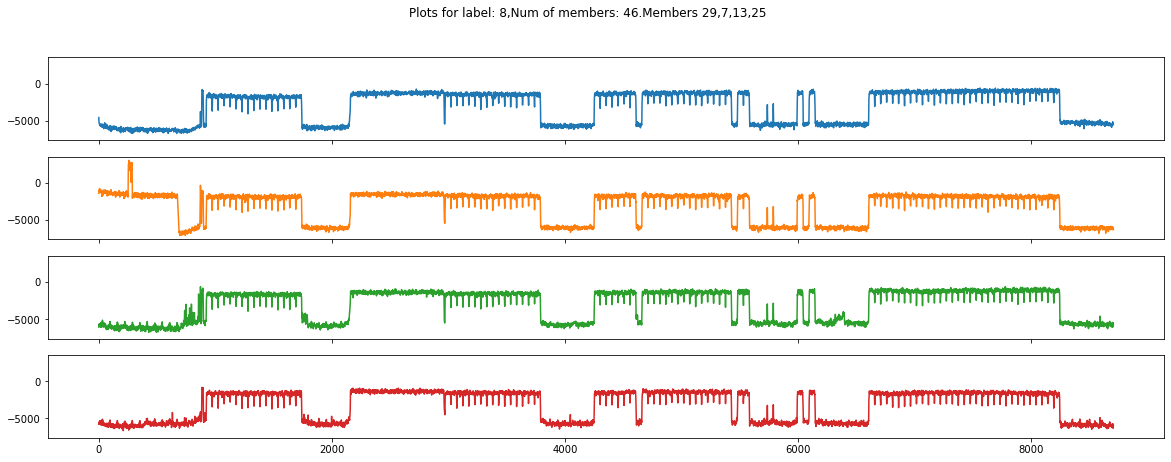

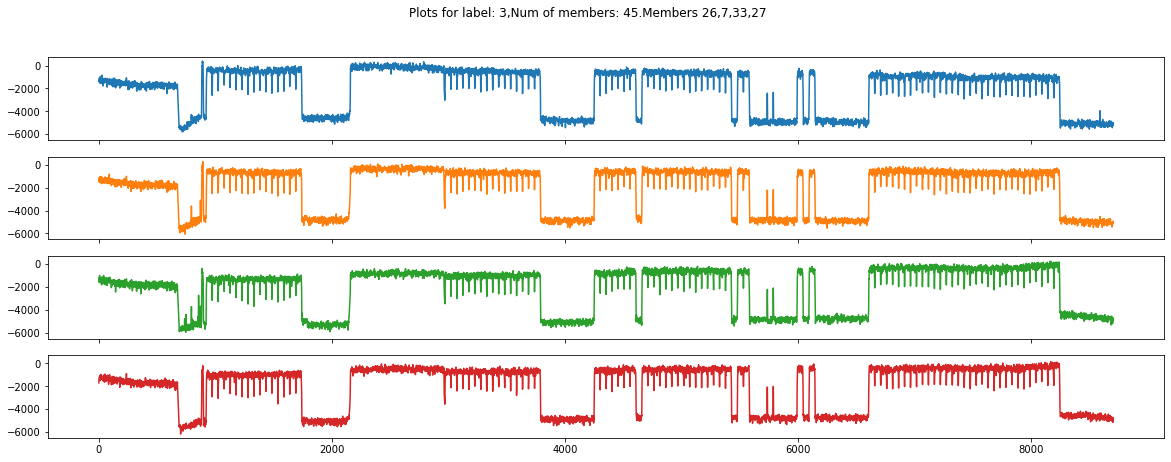

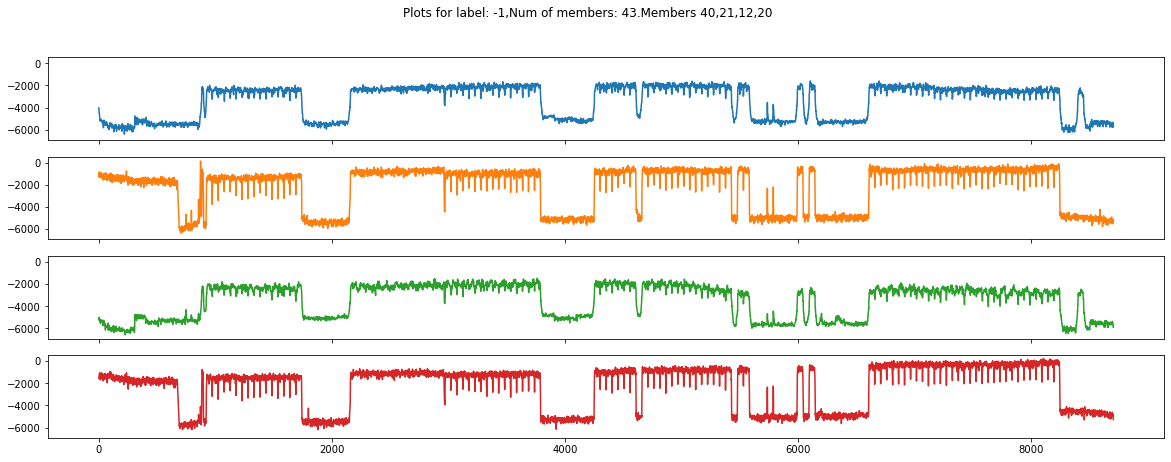

In [358]:
plot_for_all_labels(df1_with_labels,dct)

Plots for label: 4


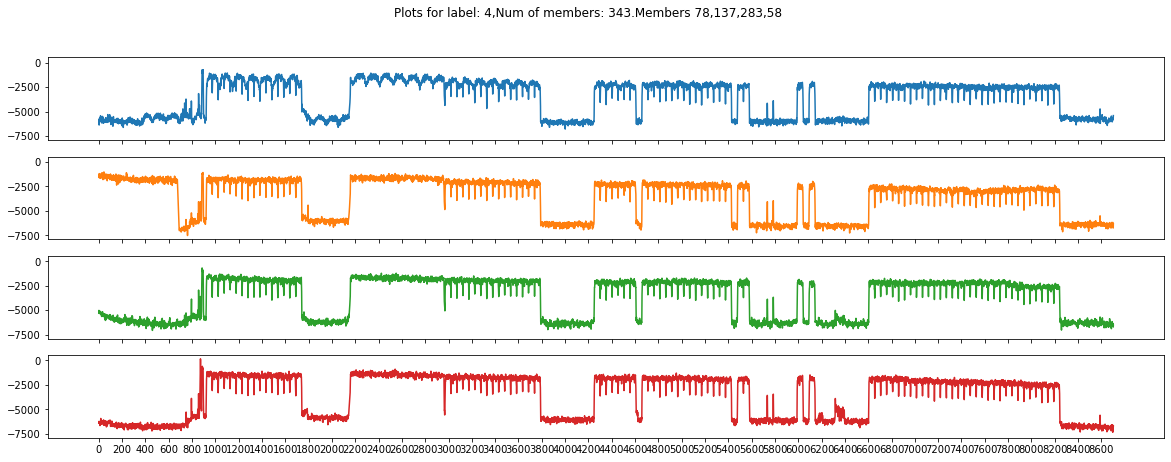

In [241]:
random_four_plot(df1_with_labels,4,343)

# Test

In [338]:
#cluster 4, members 331,90,312,18,65,299,258,167,78

In [324]:
def random_four_plot(df,label,num):
#     a= random.randint(0,num-1)
#     b= random.randint(0,num-1)
#     c= random.randint(0,num-1)
#     d= random.randint(0,num-1)
#     a=57
#     b=18
#     c=62
# #     d=60

    a=23
    b=28
    c=68
#     d=70

#     a=331
#     b=258
#     c=78
# #331,90,312,18,65,299,258,167,78
    
#     print('Plots for label: {label}'.format(label = label))
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,7),sharex = True,sharey = True)
    #fig.suptitle('Plots for label: {label},Num of members: {num}.Members {a},{b},{c},{d}'.format(label = label,num = num,a=a,b=b,c=c,d=d))
    df1_label = df1_with_labels[df1_with_labels['labels']==label].reset_index()
    
    
    ax1.plot( df1_label['amps'][a],'tab:green' )
    ax2.plot(df1_label['amps'][b] ,'tab:green'  )
    ax3.plot(df1_label['amps'][c] ,'tab:green' )
    #ax4.plot(df1_label['amps'][d]  )
    
    

    for ax in fig.get_axes():
        ax.label_outer()


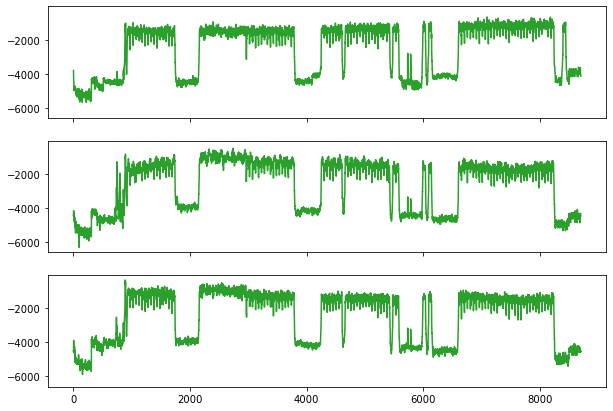

In [325]:
random_four_plot(df1_with_labels,11,111)

In [193]:
#cluster 7, members: 57,62,18,60

(57, 62, 18)

In [ ]:
#cluster 11, members: 70,23,68,28

In [310]:
def random_four_plot(df,label,num):
#     a= random.randint(0,num-1)
#     b= random.randint(0,num-1)
#     c= random.randint(0,num-1)
#     d= random.randint(0,num-1)
    a=57
#     b=62
#     c=18
#     d=60

#     a=70
#     b=23
#     c=68
#     d=28

#     a=331
#     b=258
#     c=78
# #331,90,312,18,65,299,258,167,78
    
#     print('Plots for label: {label}'.format(label = label))
    fig, (ax1) = plt.subplots(1, 1,figsize=(20,5),sharex = True,sharey = True)
    #fig.suptitle('Plots for label: {label},Num of members: {num}.Members {a},{b},{c},{d}'.format(label = label,num = num,a=a,b=b,c=c,d=d))
    df1_label = df1_with_labels[df1_with_labels['labels']==label].reset_index()
    
    
    ax1.plot( df1_label['amps'][a] )
#     ax2.plot(df1_label['amps'][b]   )
#     ax3.plot(df1_label['amps'][c]  )
#     #ax4.plot(df1_label['amps'][d]  )
    
    

    for ax in fig.get_axes():
        ax.label_outer()


In [ ]:
df1['amps'] = df1.apply(str_to_list , axis = 1)
df1 = df1[['device_id','collection_time','amps']].copy()
df1['id'] = df1.apply(lambda x : str(x[0]) + str(x[1]) , axis = 1)
df1 = df1.reset_index()

In [ ]:
#cluster 4, members 331,90,312,18,65,299,258,167,78

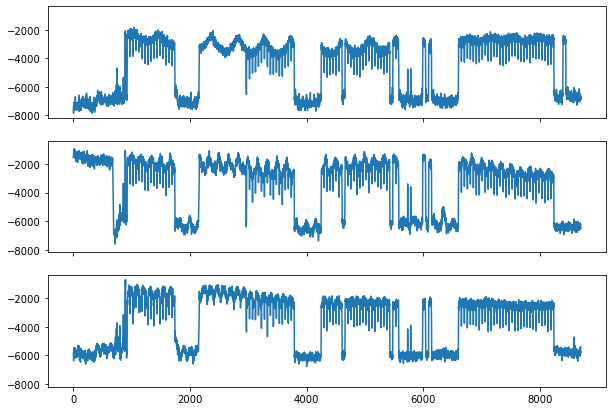

In [303]:
random_four_plot(df1_with_labels,4,111)

In [ ]:
##cluster 6 members:39,16,23

In [ ]:
#cluster 10 members:9,42,64

In [ ]:
random_four_plot(df1_with_labels,10,111)

KeyError: 111

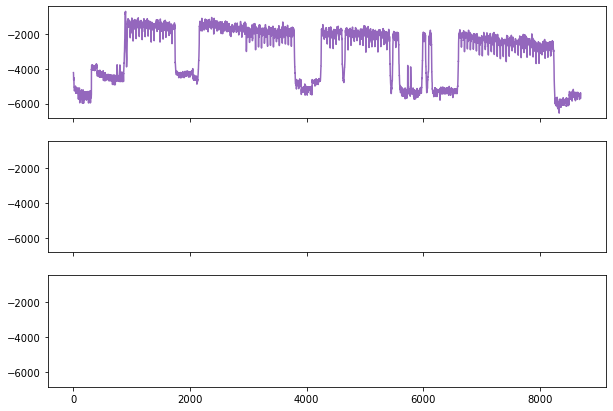

In [365]:
#def four_plots(df):
#     a= random.randint(0,num-1)
#     b= random.randint(0,num-1)
#     c= random.randint(0,num-1)
#     d= random.randint(0,num-1)
#     a=57
#     b=18
#     c=62
# #     d=60

#     a=23
#     b=28
#     c=68
# #     d=70

#     a=331
#     b=258
#     c=78
# #331,90,312,18,65,299,258,167,78
    
#     print('Plots for label: {label}'.format(label = label))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,7),sharex = True,sharey = True)
    #fig.suptitle('Plots for label: {label},Num of members: {num}.Members {a},{b},{c},{d}'.format(label = label,num = num,a=a,b=b,c=c,d=d))
#df1_label = df1_with_labels[df1_with_labels['labels']==label].reset_index()
    
    
ax1.plot( df1_with_labels[df1_with_labels['labels']==7].reset_index()['amps'][57],'tab:pink' )
ax2.plot(df1_with_labels[df1_with_labels['labels']==8].reset_index()['amps'][111],'tab:pink' )
ax3.plot(df1_with_labels[df1_with_labels['labels']==0].reset_index()['amps'][33] ,'tab:pink'  )

    #ax4.plot(df1_label['amps'][d]  )
    
    

for ax in fig.get_axes():
    ax.label_outer()
